##Observations
 1. If you are looking at the bar graphs, Capomulin and Ramicare are the highest in number of timepoints. Later, in the box and whisker plots, they have much lower values for the Final Tumor Volume. I wonder if the higher survival/success rate made a explains their higher number of timepoint, or did they simply have more mice on their drug?
 2. One of the Drug Regimens is called Placebo. I am assuming that this marks mice who aren't getting any drugs. When looking at the bar plot, it does not give much hope for the drugs that are having the same success/effectiveness.
 3. One of the steps to finding the final tumor volume, is finding the final timepoint for each mouse in that dataset. It would be very interesting to compare how long the mice lived on each of the drugs, especially the placebo patients.
 4. When you first look at the data, you notice that every mouse starts with the tumor volume of 45 mm3. (You can see this in mouse_df, and double_mouse. I double checked in the spread sheet and they all start at exactly 45. How is that possible? Wouldn't the cancer in every mouse be different?

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

In [2]:
# make paths and read csv raw data
mouse_data_path = "Resources/Mouse_metadata.csv"
mouse_results_path = "Resources/Study_results.csv"

mouse_data = pd.read_csv(mouse_data_path)
mouse_results = pd.read_csv(mouse_results_path)

In [3]:
#merge the data on coulumn "Mouse ID"
mousey_df = pd.merge(mouse_data, mouse_results, on="Mouse ID", how="outer")

mouse_df = mousey_df.rename(columns={"Age_months": "Age (m)"})

mouse_df.head()

,Mouse ID,Drug Regimen,Sex,Age (m),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [4]:
#check totals in dataframe
mouse_df.count()

Mouse ID              1893
Drug Regimen          1893
Sex                   1893
Age (m)               1893
Weight (g)            1893
Timepoint             1893
Tumor Volume (mm3)    1893
Metastatic Sites      1893
dtype: int64

In [5]:
#check number of unique mouse ID numbers
mousenum = mouse_df['Mouse ID'].nunique()
mousenum

249

In [6]:
#find duplicate mouse 
double_mouse = mouse_df[mouse_df.duplicated(['Mouse ID','Timepoint'])]
double_mouse                        

,Mouse ID,Drug Regimen,Sex,Age (m),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [7]:
#delete duplicate rows and make sure they were dropped
cleanmouse_df = mouse_df.drop(mouse_df.index[[909, 911, 913, 915, 917]])
cleanmouse_df.count()

Mouse ID              1888
Drug Regimen          1888
Sex                   1888
Age (m)               1888
Weight (g)            1888
Timepoint             1888
Tumor Volume (mm3)    1888
Metastatic Sites      1888
dtype: int64

In [8]:
#SUMMARY STATISTICS
#using groupby method
#generate a statistics summary table for tumor volume of each drug
meantv = cleanmouse_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].mean()
mediantv = cleanmouse_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].median()
variancetv = cleanmouse_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].var()
stdevtv = cleanmouse_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].std()
semtv = cleanmouse_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].sem()

#create and print dataframe for summary stats
tvstat_df = pd.DataFrame(
    {'Mean of Tumor Volume (mm3)': meantv,
    'Median of Tumor Volume (mm3)': mediantv,
    'Variance of Tumor Volume (mm3)': variancetv,
    'Standard Dev of Tumor Volume (mm3)': stdevtv,
    'SEM of Tumor Volume (mm3)': semtv})
tvstat_df

,Mean of Tumor Volume (mm3),Median of Tumor Volume (mm3),Variance of Tumor Volume (mm3),Standard Dev of Tumor Volume (mm3),SEM of Tumor Volume (mm3)
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
#using aggregation method
tvstats2 = cleanmouse_df.groupby('Drug Regimen').agg(
        mean_tv=('Tumor Volume (mm3)', np.mean),
        median_tv=('Tumor Volume (mm3)', np.median),
        varience_tv=('Tumor Volume (mm3)', np.var),
        stdev_tv=('Tumor Volume (mm3)', np.std),
        sem_tv=('Tumor Volume (mm3)', st.sem))
tvstats2

,mean_tv,median_tv,varience_tv,stdev_tv,sem_tv
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


<function matplotlib.pyplot.show>

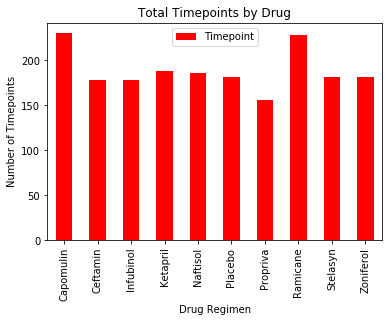

In [10]:
#BAR CHARTS
#pandas .plot method

#group by type of drug
drug_df = cleanmouse_df.groupby(['Drug Regimen'])

#find count for each drug
drugcount = drug_df['Timepoint'].count()

#create a dataframe with drug and count for that drug
#I did this rather then having to mess with creating a dictionary
drugcount_df = pd.DataFrame(drug_df['Timepoint'].count())

#create bar chart
drugcount_bar = drugcount_df.plot(kind="bar", title="Total Timepoints by Drug", color="red")

#label the chart
drugcount_bar.set_xlabel("Drug Regimen")
drugcount_bar.set_ylabel("Number of Timepoints")
plt.tight_layout

plt.show

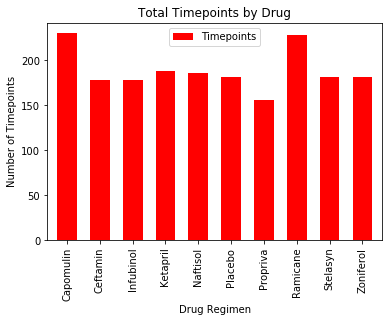

In [11]:
#using pyplot
#set xaxis and tick locations
x_axis = np.arange(len(drugcount_df))
tick_locations = [value for value in x_axis]

#create bar graph
plt.figure(figsize=(6,4))
plt.bar(x_axis, drug_df['Timepoint'].count(), color='r', width=0.6, align="center")
plt.xticks(tick_locations, list(drugcount_df.index), rotation="vertical")

#set x and y limits (i didnt see the need to mess with the ylim here)
plt.xlim(-.6, len(x_axis)-0.4)

#Label the chart
plt.title("Total Timepoints by Drug")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Timepoints")

#make a legend
columns = ['Timepoints']
plt.legend(columns, loc='best')

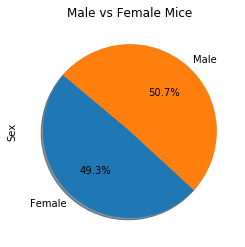

In [12]:
#PIE CHARTS
#using pandas

#group by sex
sex_df = cleanmouse_df.groupby(['Sex'])

#create a dataframe of values needed to graph
sexcount_df = pd.DataFrame(sex_df['Sex'].count())

#create pie chart
sexcount_df.plot(kind='pie', y='Sex', title= "Male vs Female Mice",startangle=140, autopct="%1.1f%%", shadow=True, legend=False)

Text(0, 0.5, 'Sex')

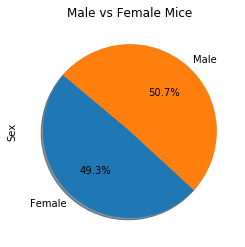

In [13]:
#using pyplot

#get values to plug into chart
sex = ["Female", "Male"]
sexcount = sexcount_df["Sex"]

#make chart
plt.pie(sexcount, labels=sex,
        autopct="%1.1f%%", shadow=True, startangle=140)

#label chart
#since theres a y label i added it even though it seemed superfluous
plt.title("Male vs Female Mice")
plt.ylabel("Sex")

In [14]:
#QUARTILES, OUTLIERS AND BOXPLOTS
#Get a new dataframe that only includes those four drugs
CRICdrugs = cleanmouse_df.loc[(cleanmouse_df["Drug Regimen"] == "Capomulin") | (
    cleanmouse_df["Drug Regimen"] == "Ramicane") | (cleanmouse_df["Drug Regimen"] == "Infubinol") | (cleanmouse_df["Drug Regimen"] == "Ceftamin"), :]

#group by the drug and the mouse ID
CRICtumor = CRICdrugs.groupby(['Drug Regimen','Mouse ID'])

#Find each final timepoint
CRICmax = pd.DataFrame(CRICtumor['Timepoint'].max())
CRICmax2 = CRICmax.rename(columns={"Timepoint": "Final Timepoint"})
CRICmax2.head()

Final Timepoint
Drug Regimen Mouse ID                 
Capomulin    b128                   45
             b742                   45
             f966                   20
             g288                   45
             g316                   45

In [15]:
#find the final tumor value for each mouse
#I could not get merge to work so I used agg instead
CRICfinal = CRICtumor.agg(finaltumor_vol=('Tumor Volume (mm3)',lambda x: x.iloc[-1]))

CRICfinal2 = CRICfinal.rename(columns={"finaltumor_vol":"Final Tumor Volume"})
CRICfinal2

Final Tumor Volume
Drug Regimen Mouse ID                    
Capomulin    b128               38.982878
             b742               38.939633
             f966               30.485985
             g288               37.074024
             g316               40.159220
...                                   ...
Ramicane     s508               30.276232
             u196               40.667713
             w678               43.166373
             y449               44.183451
             z578               30.638696

[100 rows x 1 columns]

In [16]:
#make a list of the treatments
druglist = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

#make a blank lists for outliers
outdrug = []
outfintumvol = []

#Unstack data (you can't access the drugs when in groupby)
CRICfinal_unstack = CRICfinal2.stack(level=0).unstack(level=0)
CRICfinal_unstack.head()

,Drug Regimen,Capomulin,Ceftamin,Infubinol,Ramicane
Mouse ID,,,,,
a203,Final Tumor Volume,NaN,NaN,67.973419,NaN
a251,Final Tumor Volume,NaN,NaN,65.525743,NaN
a275,Final Tumor Volume,NaN,62.999356,NaN,NaN
a411,Final Tumor Volume,NaN,NaN,NaN,38.407618
a444,Final Tumor Volume,NaN,NaN,NaN,43.047543


In [17]:
#make calculations for each drug
for x in druglist:
    quartiles = CRICfinal_unstack[x].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
        
    print(f"{x} IQR data is:")
    print(f"The lower quartile of final tumor volume is: {lowerq}")
    print(f"The upper quartile of final tumor volume is: {upperq}")
    print(f"The interquartile range of final tumor volume is: {iqr}")
    print(f"The the median of final tumor volume is: {quartiles[0.5]} ")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"-----------------------------")
    

Capomulin IQR data is:
The lower quartile of final tumor volume is: 32.37735684
The upper quartile of final tumor volume is: 40.1592203
The interquartile range of final tumor volume is: 7.781863460000004
The the median of final tumor volume is: 38.125164399999996 
Values below 20.70456164999999 could be outliers.
Values above 51.83201549 could be outliers.
-----------------------------
Ramicane IQR data is:
The lower quartile of final tumor volume is: 31.56046955
The upper quartile of final tumor volume is: 40.65900627
The interquartile range of final tumor volume is: 9.098536719999998
The the median of final tumor volume is: 36.56165229 
Values below 17.912664470000003 could be outliers.
Values above 54.30681135 could be outliers.
-----------------------------
Infubinol IQR data is:
The lower quartile of final tumor volume is: 54.04860769
The upper quartile of final tumor volume is: 65.52574285
The interquartile range of final tumor volume is: 11.477135160000003
The the median of fina

In [18]:
#create a list for final tumor volume
fintumvol = []

#run data through loop to get the final tumor volumes
#use unstacked dataframe in order to access individual drugs
#drop all data that isnt there
for x in druglist:
    fintumvol.append(list(CRICfinal_unstack[x].dropna()))

([<matplotlib.axis.XTick at 0x2a2492ee0b8>,
 <a list of 4 Text xticklabel objects>)

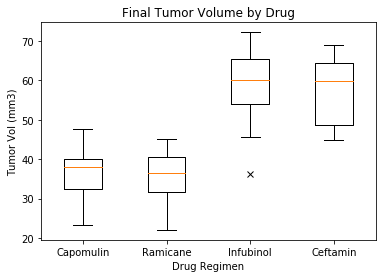

In [19]:
#box and whisker plots
fig1, ax = plt.subplots()
ax.set_title("Final Tumor Volume by Drug")
ax.set_xlabel("Drug Regimen")
ax.set_ylabel("Tumor Vol (mm3)")
ax.boxplot(fintumvol, sym = "x")
plt.xticks([1,2,3,4],druglist)

In [20]:
#Outliers
#Check here where there are outliers and for which drugs (only one off lower bound for Infubinol)
#took the really long route

#get data for Infubinol, go through all steps we did for all four drugs
Infubinol = cleanmouse_df.loc[(cleanmouse_df["Drug Regimen"] == "Infubinol")]                              
inftum = Infubinol.groupby(['Drug Regimen','Mouse ID'])                              
inffinal = inftum.agg(finaltumor_vol=('Tumor Volume (mm3)',lambda x: x.iloc[-1]))
inffinal2 = inffinal.rename(columns={"finaltumor_vol":"Final Tumor Volume"}) 
inffinal2.head()  

Final Tumor Volume
Drug Regimen Mouse ID                    
Infubinol    a203               67.973419
             a251               65.525743
             a577               57.031862
             a685               66.083066
             c139               72.226731

In [21]:
 #find outlier using IQR data previously found
inf_lower_bound = 36.83290494999999
outlier = inffinal2.loc[(inffinal2['Final Tumor Volume'] < inf_lower_bound)]
outlier

,,Final Tumor Volume
Drug Regimen,Mouse ID,
Infubinol,c326,36.321346


In [22]:
#line plot for tumor volume vs time point for a mouse
#find data for Capomulin
capomulin = cleanmouse_df.loc[cleanmouse_df['Drug Regimen'] == 'Capomulin']

#print first mouse to get id
capomulin.head()

,Mouse ID,Drug Regimen,Sex,Age (m),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
10,s185,Capomulin,Female,3,17,0,45.000000,0
11,s185,Capomulin,Female,3,17,5,43.878496,0
12,s185,Capomulin,Female,3,17,10,37.614948,0
13,s185,Capomulin,Female,3,17,15,38.177232,0
14,s185,Capomulin,Female,3,17,20,36.866876,0


In [23]:
#name the mouse and the data
pippymouse = capomulin.loc[capomulin["Mouse ID"] == "s185"]
pippymouse

,Mouse ID,Drug Regimen,Sex,Age (m),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
10,s185,Capomulin,Female,3,17,0,45.000000,0
11,s185,Capomulin,Female,3,17,5,43.878496,0
12,s185,Capomulin,Female,3,17,10,37.614948,0
13,s185,Capomulin,Female,3,17,15,38.177232,0
14,s185,Capomulin,Female,3,17,20,36.866876,0
15,s185,Capomulin,Female,3,17,25,33.949940,0
16,s185,Capomulin,Female,3,17,30,32.959671,1
17,s185,Capomulin,Female,3,17,35,28.328531,1
18,s185,Capomulin,Female,3,17,40,25.472143,1
19,s185,Capomulin,Female,3,17,45,23.343598,1


Text(0.5, 1.0, 'Tumor Volume vs Timepoint of Pippy the Capumulin Mouse')

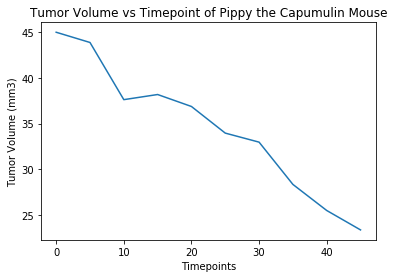

In [24]:
#get data for graph
pippytumvol = pippymouse["Tumor Volume (mm3)"]
pippytime = pippymouse["Timepoint"]

plt.plot(pippytime, pippytumvol)
plt.xlabel("Timepoints")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Tumor Volume vs Timepoint of Pippy the Capumulin Mouse")

In [25]:
#scatter plot for avg tumor vol vs mouse weight for Capomulin
#Group capomulin data by mouse ID
capmice = capomulin.groupby(['Mouse ID'])

#get needed values and set them to variables
#all weights should be the same and so the avg is just the weight
captumavg = capmice['Tumor Volume (mm3)'].mean()
capweight = capmice['Weight (g)'].mean()


Text(0, 0.5, 'Tumor Volume (mm3)')

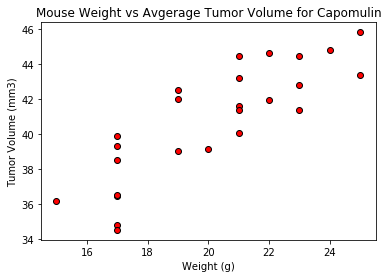

In [26]:
#make scatter plot
plt.scatter(capweight, captumavg, marker="o", facecolors="red", edgecolors="black")
plt.title("Mouse Weight vs Avgerage Tumor Volume for Capomulin")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")

In [27]:
#CORRELATION AND REGRESSION
#calculate the correllation for previous scatter plot
correlation = st.pearsonr(capweight, captumavg)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.84


The r-squared is: 0.7088568047708717
the line equation is: y = 0.95x + 21.55


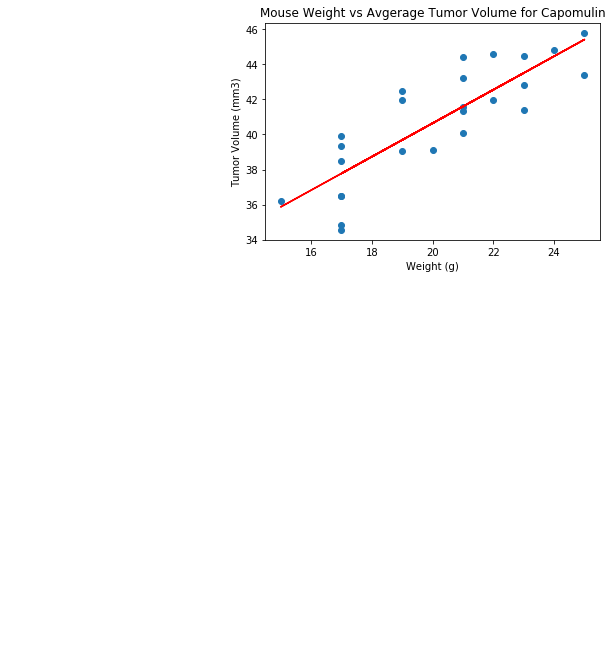

In [28]:
# linear regression
x_values = capweight
y_values = captumavg
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.title("Mouse Weight vs Avgerage Tumor Volume for Capomulin")
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
print(f"The r-squared is: {rvalue**2}")
#Im not sure why this isnt printing on the graph but i wanted to make sure it got shown
print(f"the line equation is: {line_eq}")
plt.show()